Please upload your file (CSV or Excel).
Required columns: tc_id, us_id, tc_executiontime, us_businessvalue


Saving D2.xlsx to D2.xlsx
Successfully loaded 'D2.xlsx'


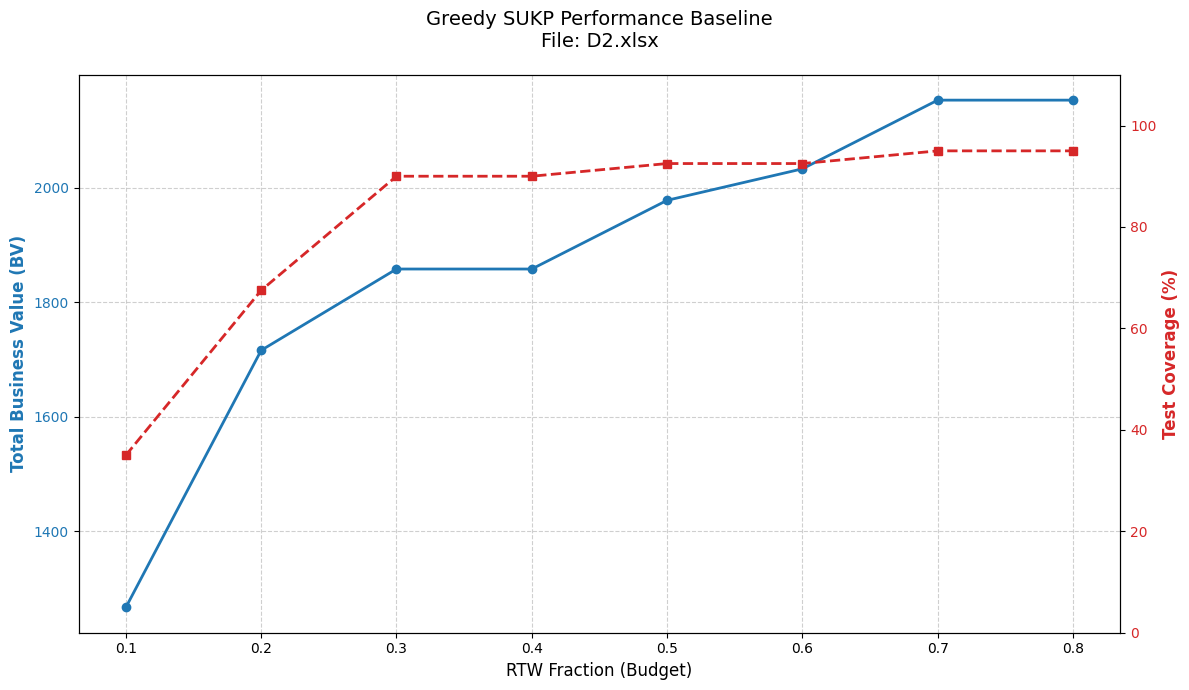

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from typing import Dict, Any, Sequence
from google.colab import files

# --------------------------------------------------------------------
# 1. FILE UPLOAD & LOADING
# --------------------------------------------------------------------
print("Please upload your file (CSV or Excel).")
print("Required columns: tc_id, us_id, tc_executiontime, us_businessvalue")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again.")
else:
    filename = list(uploaded.keys())[0]
    file_content = uploaded[filename]

    try:
        # Load the data based on file extension
        if filename.lower().endswith(('.xlsx', '.xls')):
            df_input = pd.read_excel(io.BytesIO(file_content))
        else:
            df_input = pd.read_csv(io.BytesIO(file_content), encoding='utf-8', errors='replace')

        print(f"Successfully loaded '{filename}'")

        # CONFIG: RTW_FRACTIONS
        RTW_FRACTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

        # --------------------------------------------------------------------
        # 2. GREEDY MODEL BUILDING & ALGORITHM FUNCTIONS
        # --------------------------------------------------------------------
        def build_model_greedy(df: pd.DataFrame) -> Dict[str, Any]:
            test_ids = np.sort(df["tc_id"].unique())
            req_ids  = np.sort(df["us_id"].unique())
            n_tests, n_reqs = len(test_ids), len(req_ids)

            test_index = {tc_id: i for i, tc_id in enumerate(test_ids)}
            req_index  = {us_id: i for i, us_id in enumerate(req_ids)}

            test_et = np.zeros(n_tests, dtype=float)
            for tc in test_ids:
                test_et[test_index[tc]] = float(df.loc[df["tc_id"] == tc, "tc_executiontime"].iloc[0])

            req_bv = np.zeros(n_reqs, dtype=float)
            for us in req_ids:
                req_bv[req_index[us]] = float(df.loc[df["us_id"] == us, "us_businessvalue"].iloc[0])

            req_to_tests_idx = [[] for _ in range(n_reqs)]
            test_to_reqs_idx = [[] for _ in range(n_tests)]

            for _, row in df.iterrows():
                ti, rj = test_index[row["tc_id"]], req_index[row["us_id"]]
                req_to_tests_idx[rj].append(ti)
                test_to_reqs_idx[ti].append(rj)

            return {
                "test_ids": test_ids, "req_ids": req_ids, "test_et": test_et, "req_bv": req_bv,
                "req_to_tests_idx": [np.array(tidx) for tidx in req_to_tests_idx],
                "test_to_reqs_idx": [np.array(ridx) for ridx in test_to_reqs_idx],
                "req_tests_count": np.array([len(tidx) for tidx in req_to_tests_idx]),
                "n_tests": n_tests, "n_reqs": n_reqs
            }

        def greedy_sukp_single_rtw(model: Dict[str, Any], budget: float) -> Dict[str, Any]:
            n_tests, n_reqs = model["n_tests"], model["n_reqs"]
            test_et, req_bv = model["test_et"], model["req_bv"]
            test_to_reqs_idx, req_tests_count = model["test_to_reqs_idx"], model["req_tests_count"]

            selected_tests = np.zeros(n_tests, dtype=bool)
            used_et, req_sel_count = 0.0, np.zeros(n_reqs, dtype=int)
            req_satisfied_rtw = np.zeros(n_reqs, dtype=bool)

            while True:
                best_t, best_score = -1, 0.0
                for ti in range(n_tests):
                    if selected_tests[ti] or (used_et + test_et[ti] > budget): continue

                    gain = 0.0
                    for rj in test_to_reqs_idx[ti]:
                        if not req_satisfied_rtw[rj] and (req_sel_count[rj] + 1 == req_tests_count[rj]):
                            gain += req_bv[rj]

                    if gain > 0:
                        score = gain / test_et[ti]
                        if score > best_score:
                            best_score, best_t = score, ti

                if best_t == -1: break
                selected_tests[best_t], used_et = True, used_et + test_et[best_t]
                for rj in test_to_reqs_idx[best_t]:
                    if not req_satisfied_rtw[rj]:
                        req_sel_count[rj] += 1
                        if req_sel_count[rj] == req_tests_count[rj]: req_satisfied_rtw[rj] = True

            return {
                "total_bv": float(req_bv[req_satisfied_rtw].sum()),
                "test_coverage": 100.0 * float(selected_tests.sum()) / n_tests,
                "satisfied_mask": req_satisfied_rtw
            }

        def greedy_sukp_over_rtws(df: pd.DataFrame, rtw_fractions: Sequence[float]) -> Dict[float, Dict[str, Any]]:
            model = build_model_greedy(df)
            total_et = model["test_et"].sum()
            results = {}
            for frac in rtw_fractions:
                rtw_result = greedy_sukp_single_rtw(model, float(frac) * total_et)
                results[float(frac)] = rtw_result
            return results

        # --------------------------------------------------------------------
        # 3. EXECUTION & PLOTTING
        # --------------------------------------------------------------------
        results = greedy_sukp_over_rtws(df_input, RTW_FRACTIONS)

        fractions = sorted(results.keys())
        bv_values = [results[f]['total_bv'] for f in fractions]
        cvg_values = [results[f]['test_coverage'] for f in fractions]

        fig, ax1 = plt.subplots(figsize=(12, 7))

        # Plot BV (Primary Axis)
        color_bv = 'tab:blue'
        ax1.set_xlabel('RTW Fraction (Budget)', fontsize=12)
        ax1.set_ylabel('Total Business Value (BV)', color=color_bv, fontweight='bold', fontsize=12)
        ax1.plot(fractions, bv_values, color=color_bv, marker='o', linewidth=2, label='BV')
        ax1.tick_params(axis='y', labelcolor=color_bv)
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Plot Test Coverage (Secondary Axis)
        ax2 = ax1.twinx()
        color_cvg = 'tab:red'
        ax2.set_ylabel('Test Coverage (%)', color=color_cvg, fontweight='bold', fontsize=12)
        ax2.plot(fractions, cvg_values, color=color_cvg, marker='s', linestyle='--', linewidth=2, label='Test Coverage')
        ax2.tick_params(axis='y', labelcolor=color_cvg)
        ax2.set_ylim(0, 110)

        plt.title(f'Greedy SUKP Performance Baseline\nFile: {filename}', fontsize=14, pad=20)
        fig.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing file: {e}")